# Processing natural language with Neural Networks

In [1]:
%pylab inline
plt.style.use('seaborn-talk')

Populating the interactive namespace from numpy and matplotlib


In [0]:
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show()  

## Data

Sentiment Analysis

http://ai.stanford.edu/~amaas/data/sentiment/

In [0]:
!rm -rf data
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!mkdir -p data
!mv aclImdb_v1.tar.gz data/
!cd data && tar zxf aclImdb_v1.tar.gz

--2019-01-11 22:17:31--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  25.2MB/s    in 3.2s    

2019-01-11 22:17:34 (25.2 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [0]:
!du -hs data

571M	data


Of all the files included in the data directory, we will focus on the following directories:

The training data:

* train/pos
* train/neg

The test data:

* test/pos
* test/neg

The contents are just text files, and the subdirectories are the corresponding label for the review of the movie. Those will be the labels of our data.

Those text files are small enough to be loaded in memory (~ 50 MB per label and set).

In [0]:
import os

base_dir = 'data/aclImdb/'
datasets = ['train', 'test']
labels = ['neg', 'pos']

# This dictionary will contain two keys, train and test
# Each key will have a dictionary with the texts and the labals
# d -> train -> text
#               y
#      test  -> ... 
d = {}

for dataset in datasets:
    # Init this dataset
    d[dataset] = {'text': [], 'y': []}
    print("Now filling the %s set" % dataset)
    for label in labels:
        print("  Reading the %s reviews" % label)
        k = 1
        y = labels.index(label)  # 0 for neg, 1 for pos
        dataset_dir = base_dir + "/" + dataset + "/" + label
        for fn in os.listdir(dataset_dir):
            d[dataset]['y'].append(y)
            path = dataset_dir + "/" + fn
            # We read each line, and then we keep a string with words separated by spaces
            review_text = " ".join([l.strip() for l in open(path, 'r').readlines()])
            d[dataset]['text'].append(review_text)
            k += 1
            if k % 1000 == 0:
                print("    %d reviews read..." % k)


Now filling the train set
  Reading the neg reviews
    1000 reviews read...
    2000 reviews read...
    3000 reviews read...
    4000 reviews read...
    5000 reviews read...
    6000 reviews read...
    7000 reviews read...
    8000 reviews read...
    9000 reviews read...
    10000 reviews read...
    11000 reviews read...
    12000 reviews read...
  Reading the pos reviews
    1000 reviews read...
    2000 reviews read...
    3000 reviews read...
    4000 reviews read...
    5000 reviews read...
    6000 reviews read...
    7000 reviews read...
    8000 reviews read...
    9000 reviews read...
    10000 reviews read...
    11000 reviews read...
    12000 reviews read...
Now filling the test set
  Reading the neg reviews
    1000 reviews read...
    2000 reviews read...
    3000 reviews read...
    4000 reviews read...
    5000 reviews read...
    6000 reviews read...
    7000 reviews read...
    8000 reviews read...
    9000 reviews read...
    10000 reviews read...
    11000 revi

### Transforming texts into a tensor

In the previous notebook, we transformed text into 1-HOT encoded vectores. We will use now a different approach, that overcomes some of the shortcomings of using a 1-HOT representation for texts.

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [0]:
max_words = 10000
tokenizer = Tokenizer(max_words)

In [0]:
# Now we "fit" this tokenizer over our text (e.g. to make sure we use a common vocab. index for all the reviews)
tokenizer.fit_on_texts(d['train']['text'] + d['test']['text'])

In [0]:
x_train = tokenizer.texts_to_sequences(d['train']['text'])
x_test = tokenizer.texts_to_sequences(d['test']['text'])

In [0]:
max_len = 500  # maximum length of the reviews

In [0]:
from tensorflow.keras.preprocessing import sequence

In [0]:
x_train = sequence.pad_sequences(x_train, max_len)
x_test = sequence.pad_sequences(x_test, max_len)

## Word embeddings

Using 1-HOT encoded vectors produce large and sparse tensors, that are difficult to learn from using a neural network. Word embeddings are compact vectors, representing words in a vector space. These vectors are learnt in a neural network, with a layer of type *Embedding*. We can also even use pre-trained word embeddings, to improve our model

![](./imgs/07_embeddings.png)

To generate  an embedding, we need to tokenize the text, transforming words into indices, and then we use these lists of numbers to produce the vectorial representation:

![](./imgs/08_embeddings.png)

More info:
* http://www.offconvex.org/2015/12/12/word-embeddings-1/
* http://www.offconvex.org/2016/02/14/word-embeddings-2/

In [0]:
embedding_dim = 100  # number of components of the embedding vector

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import losses

In [0]:
import tensorflow as tf
import os

In [0]:
def keras2tpu(m):
  tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    m,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])))

  return tpu_model

In [0]:
def build_model():
    m = models.Sequential()    
    m.add(layers.Embedding(max_words, embedding_dim, input_shape=(max_len,)))
    m.add(layers.LSTM(embedding_dim, return_sequences=True))
    m.add(layers.LSTM(64, return_sequences=True))
    m.add(layers.LSTM(64, return_sequences=True))
    m.add(layers.LSTM(32, return_sequences=True))
    m.add(layers.LSTM(16))
    m.add(layers.Dense(1, activation='sigmoid'))

    return m

In [25]:
m = keras2tpu(build_model())

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.94.82.218:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 9178621702697556470)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 4362998630956681205)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 3841464593767583391)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17523267125014130080)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 12506742661793111006)
INFO:tensorflow:*** Available Device: _Device

In [26]:
m.__class__

tensorflow.contrib.tpu.python.tpu.keras_support.KerasTPUModel

In [0]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1_input (InputLaye (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 500, 100)          80400     
_________________________________________________________________
lstm_6 (LSTM)                (None, 500, 64)           42240     
_________________________________________________________________
lstm_7 (LSTM)                (None, 500, 64)           33024     
_________________________________________________________________
lstm_8 (LSTM)                (None, 500, 32)           12416     
_________________________________________________________________
lstm_9 (LSTM)                (None, 16)                3136      
__________

In [0]:
m.compile(loss=losses.binary_crossentropy, optimizer=optimizers.RMSprop(), metrics=[metrics.binary_accuracy])

INFO:tensorflow:Cloning RMSprop {'lr': 0.0010000000474974513, 'rho': 0.8999999761581421, 'decay': 0.0, 'epsilon': 1e-07}


In [0]:
h = m.fit(x_train, d['train']['y'], epochs=40, batch_size=2048, validation_split=.2)

Train on 25000 samples, validate on 5000 samples
Epoch 1/40
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(256,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(256, 500), dtype=tf.float32, name='embedding_1_input_10'), TensorSpec(shape=(256, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning RMSprop {'lr': 0.0010000000474974513, 'rho': 0.8999999761581421, 'decay': 0.0, 'epsilon': 1e-07}
INFO:tensorflow:Remapping placeholder for embedding_1_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.RMSprop object at 0x7fe376d09eb8> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 21.697879552841187 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.0010000000474974513 {0.001}
INFO:tensorflow:CPU -> TPU rho: 0.8999999761581421 {0.9}
INFO:tensorflow:CPU -> TPU decay: 0.0 {0.0}
225

## Evaluate performance

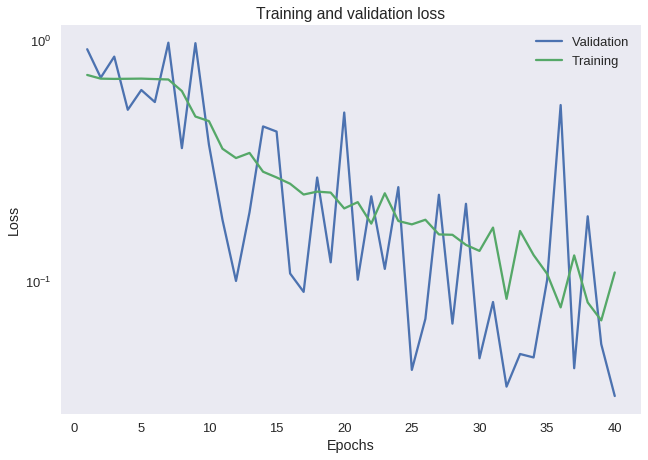

In [0]:
plot_metric(h, 'loss')

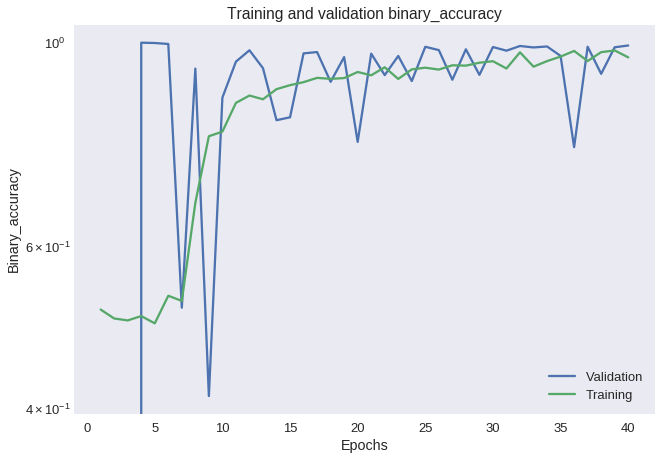

In [0]:
plot_metric(h, 'binary_accuracy')

In [0]:
m.evaluate(x_test, d['test']['y'], batch_size=2048)

24576/25000 [============================>.] - ETA: 0sINFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(53,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(53, 500), dtype=tf.float32, name='embedding_1_input_10'), TensorSpec(shape=(53, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for embedding_1_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.RMSprop object at 0x7fe36e72eeb8> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 22.65294337272644 secs
25000/25000 [==============================] - 39s 2ms/step


[0.5186929449272156, 0.8448000007247924]

# Pre-created embeddings 

Several research groups and companies share embeddings for natural languages, that have been obtained by different methods over large corpuses of text. Here we will use one of these datasets of embeddings for the English language, and will evaluate if these embeddings improve our model.

https://nlp.stanford.edu/projects/glove/

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-01-11 22:19:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-01-11 22:19:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  33.1MB/s    in 21s     

2019-01-11 22:19:37 (39.4 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [0]:
!mkdir -p data/glove && cd data/glove && unzip ../../glove.6B.zip && rm ../../glove.6B.zip

Archive:  ../../glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
!head data/glove/glove.6B.100d.txt

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062
, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.52158 

In [0]:
glove_dir = 'data/glove/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [0]:
embedding_matrix.shape

(10000, 100)

In [0]:
def build_model(embedding_weights = None):
    m = models.Sequential()    
    m.add(layers.Embedding(max_words, embedding_dim, input_shape=(max_len,)))
    if embedding_weights is not None:
      m.layers[0].set_weights([embedding_weights])
      m.layers[0].trainable = False
    m.add(layers.LSTM(embedding_dim, return_sequences=True))
    m.add(layers.LSTM(64, return_sequences=True))
    m.add(layers.LSTM(64, return_sequences=True))
    m.add(layers.LSTM(32, return_sequences=True))
    m.add(layers.LSTM(16))
    m.add(layers.Dense(1, activation='sigmoid'))

    return m

In [0]:
m_pretr = keras2tpu(build_model(embedding_matrix))

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.54.81.194:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 7271327173029181255)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14397500742808739375)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 6813413877338729620)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 12544081206606883767)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 3101747545232775453)
INFO:tensorflow:*** Available Device: _Device

In [0]:
m_pretr.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1_input (InputLaye (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 500, 100)          80400     
_________________________________________________________________
lstm_6 (LSTM)                (None, 500, 64)           42240     
_________________________________________________________________
lstm_7 (LSTM)                (None, 500, 64)           33024     
_________________________________________________________________
lstm_8 (LSTM)                (None, 500, 32)           12416     
_________________________________________________________________
lstm_9 (LSTM)                (None, 16)                3136      
__________

In [0]:
m_pretr.compile(loss=losses.binary_crossentropy, optimizer=optimizers.RMSprop(), metrics=[metrics.binary_accuracy])

INFO:tensorflow:Cloning RMSprop {'lr': 0.0010000000474974513, 'rho': 0.8999999761581421, 'decay': 0.0, 'epsilon': 1e-07}


In [0]:
h = m_pretr.fit(x_train, d['train']['y'], epochs=40, batch_size=2048, validation_split=.2)

Train on 25000 samples, validate on 5000 samples
Epoch 1/40
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(256,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(256, 500), dtype=tf.float32, name='embedding_1_input_10'), TensorSpec(shape=(256, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning RMSprop {'lr': 0.0010000000474974513, 'rho': 0.8999999761581421, 'decay': 0.0, 'epsilon': 1e-07}
INFO:tensorflow:Remapping placeholder for embedding_1_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.RMSprop object at 0x7f3f8aec5cc0> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 14.939908742904663 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.0010000000474974513 {0.001}
INFO:tensorflow:CPU -> TPU rho: 0.8999999761581421 {0.9}
INFO:tensorflow:CPU -> TPU decay: 0.0 {0.0}
225

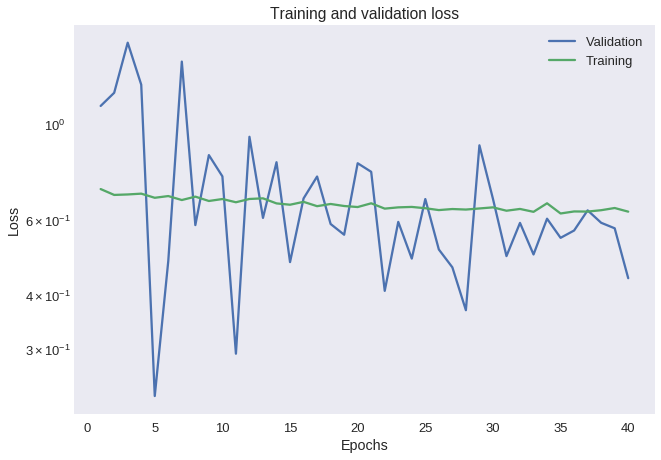

In [0]:
plot_metric(h, 'loss')

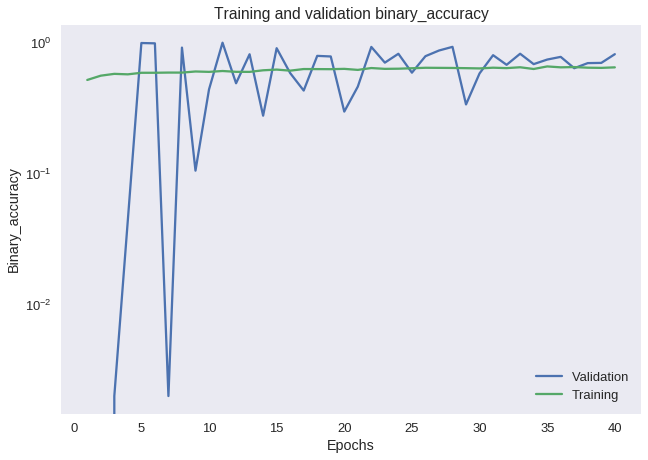

In [0]:
plot_metric(h, 'binary_accuracy')

In [0]:
m_pretr.evaluate(x_test, d['test']['y'], batch_size=2048)

24576/25000 [============================>.] - ETA: 0sINFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(53,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(53, 500), dtype=tf.float32, name='embedding_1_input_10'), TensorSpec(shape=(53, 1), dtype=tf.float32, name='dense_1_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for embedding_1_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.RMSprop object at 0x7f3f808eea58> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 22.17019486427307 secs
25000/25000 [==============================] - 38s 2ms/step


[0.6385342842960358, 0.6481600000762939]

In [0]:
def build_model(embedding_weights = None):
    m = models.Sequential()    
    m.add(layers.Embedding(max_words, embedding_dim, input_shape=(max_len,)))
    if embedding_weights is not None:
      m.layers[0].set_weights([embedding_weights])
      m.layers[0].trainable = True
    m.add(layers.LSTM(embedding_dim, return_sequences=True))
    m.add(layers.LSTM(64, return_sequences=True))
    m.add(layers.LSTM(64, return_sequences=True))
    m.add(layers.LSTM(32, return_sequences=True))
    m.add(layers.LSTM(16))
    m.add(layers.Dense(1, activation='sigmoid'))

    return m

In [0]:
m_pretr2 = keras2tpu(build_model(embedding_matrix))
m_pretr2.summary()
m_pretr2.compile(loss=losses.binary_crossentropy, optimizer=optimizers.RMSprop(), metrics=[metrics.binary_accuracy])
h = m_pretr2.fit(x_train, d['train']['y'], epochs=40, batch_size=2048, validation_split=.2)

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.54.81.194:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 7271327173029181255)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14397500742808739375)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 6813413877338729620)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 12544081206606883767)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 3101747545232775453)
INFO:tensorflow:*** Available Device: _Device

In [0]:
m_pretr.evaluate(x_test, d['test']['y'], batch_size=2048)

25000/25000 [==============================] - 2s 76us/step


[1.5968621810913086, 0.87376]